# Kod do wygenerownia i porównania różnych modeli klasyfikacji (miara accuracy)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
np.random.seed = 42

In [2]:
# Wczytanie danych
train_data = pd.read_csv("train_data_with_features.csv")
test_data = pd.read_csv("test_data_with_features.csv")

In [3]:
# Przygotowanie cech i etykiet
y_train = train_data['class']
X_train = train_data.drop(['class', "path", "filename", "R", "G", "B", "brightness"], axis=1)
y_test = test_data['class']
X_test = test_data.drop(['class', "path", "filename", "R", "G", "B", "brightness"], axis=1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

model1 = DecisionTreeClassifier()
model2 = KNeighborsClassifier()
model3 = LogisticRegression( max_iter=1000)
estimators=[('DecisionTree', model1), ('KNN', model2), ('LR', model3)]

## SoftVote Weights

In [5]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
model_soft = VotingClassifier(estimators=estimators, voting='soft', weights=[0.15, 0.65, 0.20])
model_soft.fit(X_train, y_train)

y_hat = model_soft.predict(X_test)
accuracy_score(y_test, y_hat)

0.90625

## Stacking

In [6]:
from sklearn.ensemble import StackingClassifier

In [7]:
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train).score(X_test, y_test)

0.9114583333333334

## Bootstrap Aggregating

In [8]:
from sklearn.ensemble import BaggingClassifier

In [9]:
clf = BaggingClassifier(estimator=model3,
                        n_estimators=10, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.84375

## Boosting

In [10]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.375

## Gradient Boosting

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(random_state=1,
                                  learning_rate=0.01) # Szybkość "uczenia" się 
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.8541666666666666

In [12]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Inicjalizacja LabelEncoder
label_encoder = LabelEncoder()

# Zakodowanie etykiet na liczby
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Inicjalizacja modelu XGBClassifier
model = XGBClassifier(random_state=1,
                      learning_rate=0.01, 
                      booster='gbtree', 
                      max_depth=4)

# Trenowanie modelu
model.fit(X_train, y_train_encoded)

# Predykcja
y_pred = model.predict(X_test)

# Ocena dokładności
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Dokładność modelu: {accuracy:.4f}")

Dokładność modelu: 0.8750


In [13]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
import warnings
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')

In [14]:
# przygotowanie stacking
def get_stacking():
    
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('cart', DecisionTreeClassifier(random_state=1)))
    level0.append(('rf', RandomForestClassifier(n_estimators=1000, # Ilość słabych estymatorów
                                      max_depth=2, # Maksymalna wysokość drzewa w słabym estymatorze
                                      min_samples_split = 2, # Minimalna ilość obserwacji wymagana do podziału węzła
                                      max_features = 3, # Maksymalna ilość zmiennych brana pod uwagę przy podziale węzła
                                      random_state=0,
                                      n_jobs = -1)))
    level0.append(('aboost', AdaBoostClassifier(random_state=1)))
    level0.append(('gboost', GradientBoostingClassifier(random_state=1,
                                      learning_rate=0.01)))
    level0.append(('xgb', XGBClassifier(random_state=1,
                        learning_rate=0.01, # Szybkość "uczenia" się
                        booster='gbtree', # Jaki model wykorzystujemy (drzewo - gbtree, liniowe - gblinear)
                        max_depth=4 # Maksymalna głębokość drzewa 
                        )))
    level0.append(('svm', SVC()))
    level0.append(('bayes', GaussianNB()))
    
    # definicja meta learner model
    level1 = LogisticRegression()
    
    # definicja stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    
    return model

In [15]:
# lista modeli
def get_models():
    
    models = dict()
    models['lr'] = LogisticRegression()
    models['cart'] = DecisionTreeClassifier()
    models['rf'] = RandomForestClassifier(n_estimators=1000, # Ilość słabych estymatorów
                                      max_depth=2, # Maksymalna wysokość drzewa w słabym estymatorze
                                      min_samples_split = 2, # Minimalna ilość obserwacji wymagana do podziału węzła
                                      max_features = 3, # Maksymalna ilość zmiennych brana pod uwagę przy podziale węzła
                                      random_state=0,
                                      n_jobs = -1)
    models['aboost'] = AdaBoostClassifier(random_state=1)
    models['gboost'] = GradientBoostingClassifier(random_state=1,
                                      learning_rate=0.01)
    models['xgb'] = XGBClassifier(random_state=1,
                        learning_rate=0.01, # Szybkość "uczenia" się
                        booster='gbtree', # Jaki model wykorzystujemy (drzewo - gbtree, liniowe - gblinear)
                        max_depth=4 # Maksymalna głębokość drzewa 
                        )
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['stacking'] = get_stacking()

    return models

In [16]:
# ocena modeli przy wykorzystaniu cross-validation
def evaluate_model(model, X, y):
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

    return scores


### uwaga! może zająć dużo czasu

In [17]:
# modele do evaluacji
models = get_models()

# Zakodowanie etykiet na liczby
y_encoded = label_encoder.fit_transform(y_test)
X=X_test

# ocena modeli
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y_encoded)
    results.append(scores)
    names.append(name)
    print('%8s mean-%.3f std-%.3f' % (name, np.mean(scores), np.std(scores)))

      lr mean-0.741 std-0.074
    cart mean-0.698 std-0.077
      rf mean-0.640 std-0.088
  aboost mean-0.285 std-0.088
  gboost mean-0.726 std-0.091
     xgb mean-0.703 std-0.086
     svm mean-0.636 std-0.083
   bayes mean-0.639 std-0.080
stacking mean-0.687 std-0.082


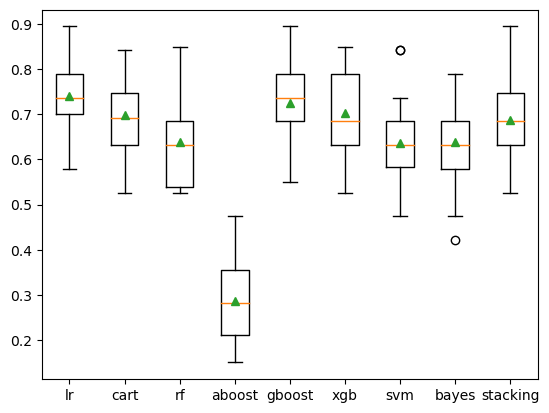

In [18]:
# plot acc dla modeli i stacking
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# Do sprawdzenia istotności cech

In [19]:
clf = RandomForestClassifier(n_estimators=100,  max_depth=7)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7)

In [20]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)

# Ocena modelu
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f"Dokładność modelu: {accuracy:.4f}")
print("Raport klasyfikacji:\n", report)

Dokładność modelu: 0.8958
Raport klasyfikacji:
                       precision    recall  f1-score   support

      Bombali Ghevda       0.83      0.62      0.71        16
        Butka Ghevda       0.94      1.00      0.97        16
       Gabara Ghevda       1.00      1.00      1.00        16
             God Wal       0.74      0.88      0.80        16
          Hirva Lamb       0.93      0.88      0.90        16
            Kadu wal       0.75      0.94      0.83        16
            Kala Wal       0.89      1.00      0.94        16
     Lal lamb shenga       0.87      0.81      0.84        16
Lamb Shiracha Ghevda       0.93      0.88      0.90        16
      Shravan Ghevda       1.00      0.88      0.93        16
          Tambda wal       1.00      1.00      1.00        16
       Vatana Ghevda       0.93      0.88      0.90        16

            accuracy                           0.90       192
           macro avg       0.90      0.90      0.90       192
        weighted avg

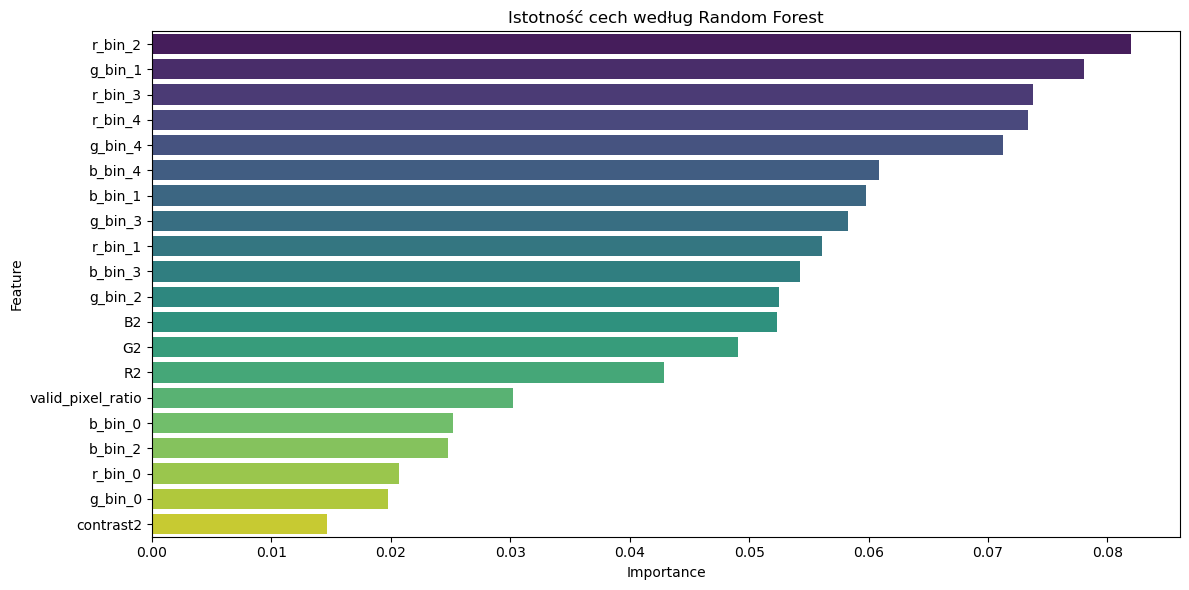

In [21]:
import seaborn as sns
# Tworzymy DataFrame z istotnościami
feature_importance = pd.DataFrame({
    'Feature': train_data.drop(['class', "path", "filename", "R", "G", "B", "brightness"],axis=1).columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Wykres
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
plt.title('Istotność cech według Random Forest')
plt.tight_layout()
plt.show()